In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re

import scipy as sp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import datasets, model_selection, metrics
from scipy.stats import ttest_ind
from scipy import stats
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import scipy.stats as st

#### Loading and preparing the data


In [2]:
#import dataset
df = pd.read_csv("../Dataset/cleaned/df_cleaned.csv")
df.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,2024-08-05 13:08:00,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,2024-08-05 10:29:00,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,2024-08-05 13:23:00,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,2024-08-05 20:33:00,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,2024-08-05 10:37:00,Ewallet,604.17,4.761905,30.2085,5.3


In [3]:
# Convert 'date' and 'time' columns to datetime
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   invoice_id               1000 non-null   object        
 1   branch                   1000 non-null   object        
 2   city                     1000 non-null   object        
 3   customer_type            1000 non-null   object        
 4   gender                   1000 non-null   object        
 5   product_line             1000 non-null   object        
 6   unit_price               1000 non-null   float64       
 7   quantity                 1000 non-null   int64         
 8   tax_5                    1000 non-null   float64       
 9   total                    1000 non-null   float64       
 10  date                     1000 non-null   datetime64[ns]
 11  time                     1000 non-null   datetime64[ns]
 12  payment                  1000 non-n

#### Quick EDA

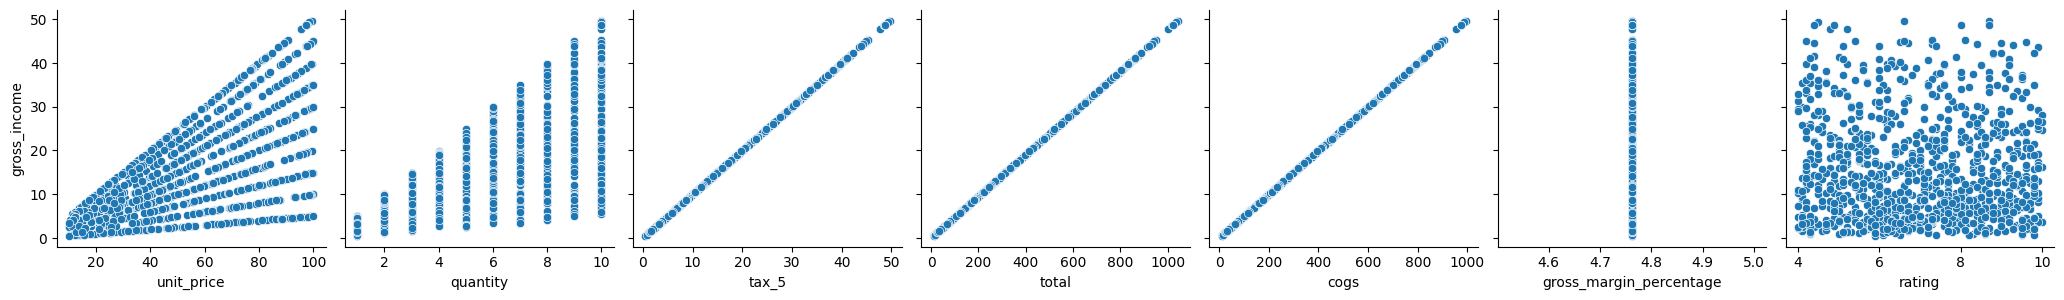

In [5]:
# Select numeric columns (we will assume you want to plot against all other numeric columns)
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
numeric_columns.remove('gross_income')  

# Create a pairplot for 'gross_income' against all other numeric columns
sns.pairplot(df, y_vars=['gross_income'], x_vars=numeric_columns, kind='scatter', height=3)
plt.show()

****
1. **Unit Price vs. Gross Income**:

There is a clear positive relationship, suggesting that as unit price increases, gross income also tends to increase.
This variable could be a strong predictor for a regression model focusing on revenue or profitability.

2. **Quantity vs. Gross Income**:

The relationship shows distinct levels of gross income increasing with quantity, though the steps are discrete (likely due to distinct quantity values in sales transactions).
It suggests quantity is a good predictor for gross income, with more items sold typically increasing total gross income.

3. **Tax 5% vs. Gross Income**:

There is a perfect linear relationship, as expected, because tax is a percentage of the total or gross sales, indicating that this is not an independent predictor but rather a direct calculation from the gross income.

4. **Total vs. Gross Income**:

Another perfect linear relationship, indicating that total sales directly influence gross income (gross income is likely derived directly from total sales values).

5. **COGS (Cost of Goods Sold) vs. Gross Income**:

This shows a linear relationship as well, highlighting that as COGS increases, gross income also increases. This could imply that higher-cost items or more items (higher COGS) are driving higher income, which could be a critical factor in profitability analysis.

6. **Gross Margin Percentage vs. Gross Income**:

There is a high concentration of data points at a specific gross margin percentage value, showing very little variation in gross margin percentage across different levels of gross income. This suggests that the gross margin percentage is relatively stable or set by policy/pricing strategy and might not be a dynamic predictor in the model.

7. **Rating vs. Gross Income**:

The relationship is scattered with no clear trend between customer ratings and gross income, indicating that customer satisfaction as measured by ratings does not directly correlate to the gross income generated.
It might not be a significant predictor of gross income.

#### Train Test Split
First we need to distinguish from features and target

In [6]:
features = df.drop(columns = ["gross_income"])
target = df["gross_income"]

#### With this function we split data into X = 80%, Y = 80%
Now we perform the division between Train and Test, we will reserve 20% of our data to Test.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 16), (200, 16), (800,), (200,))

In [9]:
X_train.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,rating
687,648-83-1321,A,Yangon,Member,Male,Home and lifestyle,63.56,10,31.7800,667.3800,2019-01-16,2024-08-05 17:59:00,Cash,635.60,4.761905,4.3
500,277-63-2961,B,Mandalay,Member,Male,Sports and travel,73.97,1,3.6985,77.6685,2019-02-03,2024-08-05 15:53:00,Credit card,73.97,4.761905,5.4
332,566-71-1091,A,Yangon,Normal,Male,Fashion accessories,77.02,5,19.2550,404.3550,2019-02-03,2024-08-05 15:59:00,Cash,385.10,4.761905,5.5
979,151-33-7434,B,Mandalay,Normal,Female,Food and beverages,67.77,1,3.3885,71.1585,2019-02-04,2024-08-05 20:43:00,Credit card,67.77,4.761905,6.5
817,832-51-6761,A,Yangon,Normal,Male,Food and beverages,33.88,8,13.5520,284.5920,2019-01-19,2024-08-05 20:29:00,Ewallet,271.04,4.761905,9.6


In [10]:
y_train.head()

687    31.7800
500     3.6985
332    19.2550
979     3.3885
817    13.5520
Name: gross_income, dtype: float64

Now, we will use KNN Regressor, we will use hyperparameter n_neighbors = 10.

In [13]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=10)